# VIX Forecast using Wavelet (CWT) and ARIMA

In [ ]:
!pip install yfinance statsmodels pandas numpy matplotlib scipy

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
<ipython-input-2-357913666092>:19: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  cwt_matrix = cwt(vix.values.flatten(), ricker, widths)  # Apply CWT
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


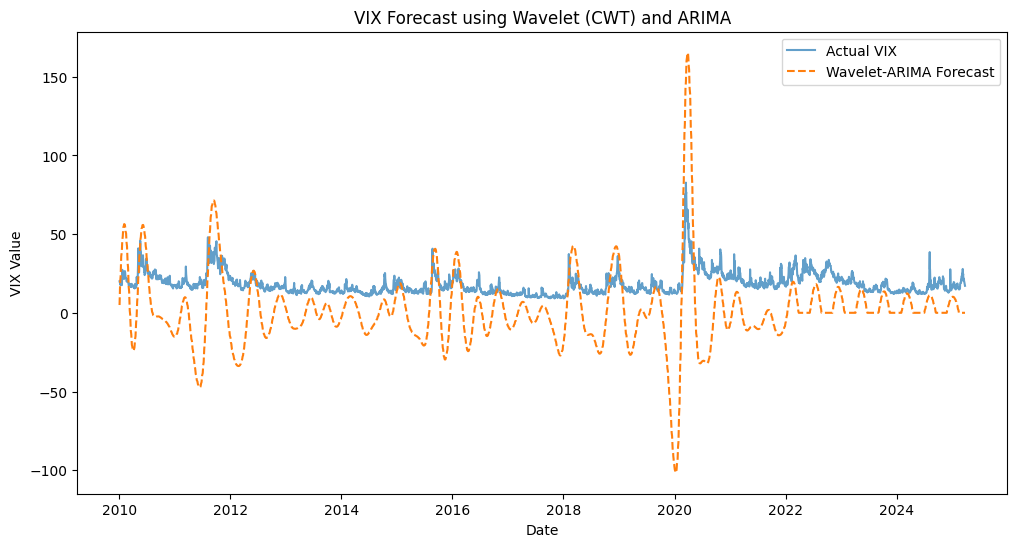

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from scipy.signal import cwt, ricker

import datetime as dt
from datetime import datetime

end_time = dt.date.today().strftime("%Y-%m-%d")

# Step 1: Download VIX Data
vix = yf.download("^VIX", start="2010-01-01", end=end_time)['Close']

# Step 2: Apply Continuous Wavelet Transform (CWT) using Ricker Wavelet
widths = np.arange(1, 31)  # Wavelet scales (acts like frequency bands)
# Convert vix values to a 1-dimensional array
cwt_matrix = cwt(vix.values.flatten(), ricker, widths)  # Apply CWT

# Step 3: Extract Key Features from Wavelet Transform
low_freq_component = np.mean(cwt_matrix[-5:], axis=0)  # Approximate trend (low frequency)
high_freq_component = np.mean(cwt_matrix[:5], axis=0)  # Volatility (high frequency)

# Step 4: Train ARIMA Model on Low-Frequency Component
train_size = int(len(low_freq_component) * 0.8)
train, test = low_freq_component[:train_size], low_freq_component[train_size:]

model = ARIMA(train, order=(2,1,2))
model_fit = model.fit()

# Step 5: Forecast Future Values
forecast_steps = len(test)
forecast = model_fit.forecast(steps=forecast_steps)
forecast = np.maximum(0, forecast)  # Ensure non-negative VIX values

# Step 6: Reconstruct Forecasted Signal
reconstructed_signal = np.concatenate([train, forecast])

# Ensure the forecasted signal has the same length as VIX data
if len(reconstructed_signal) > len(vix):
    reconstructed_signal = reconstructed_signal[:len(vix)]
elif len(reconstructed_signal) < len(vix):
    reconstructed_signal = np.pad(reconstructed_signal, (0, len(vix) - len(reconstructed_signal)), 'edge')

# Step 7: Plot Results
plt.figure(figsize=(12,6))
plt.plot(vix.index, vix, label="Actual VIX", alpha=0.7)
plt.plot(vix.index, reconstructed_signal, label="Wavelet-ARIMA Forecast", linestyle="--")
plt.legend()
plt.title("VIX Forecast using Wavelet (CWT) and ARIMA")
plt.xlabel("Date")
plt.ylabel("VIX Value")
plt.show()

# VIX Forecast using Scipy Wavelet + XGBoost

[*********************100%***********************]  1 of 1 completed
<ipython-input-3-89286e7e1fa9>:30: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  cwt_matrix = cwt(vix['Close'].values.reshape(-1,), ricker, widths)  # Apply CWT


Mean Absolute Error (MAE): 3.97
Root Mean Squared Error (RMSE): 5.19


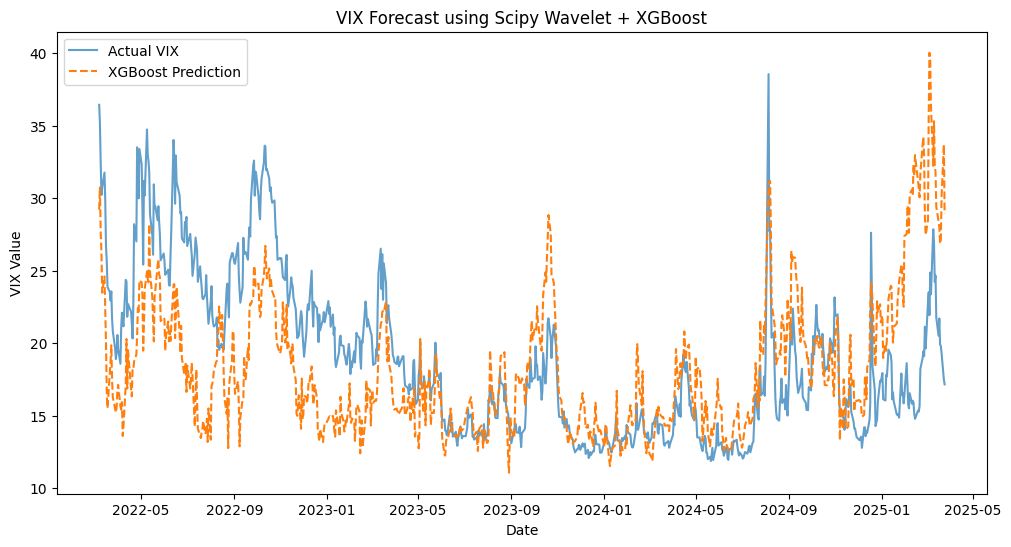

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.signal import cwt, ricker
import datetime as dt

# Get today's date for real-time analysis
end_time = dt.date.today().strftime("%Y-%m-%d")

# Step 1: Download VIX Data
vix = yf.download("^VIX", start="2010-01-01", end=end_time)

# Check if data was successfully downloaded
if vix.empty:
    raise ValueError("Yahoo Finance returned an empty dataset. Check the ticker or API availability.")

# Fix missing 'Close' column issue
if 'Close' not in vix.columns:
    vix['Close'] = vix.get('Adj Close', vix.get('close', vix.get('adj close')))

vix = vix[['Close']].dropna().reset_index()  # Keep only Close column & clean data

# Step 2: Apply Continuous Wavelet Transform (CWT) using Ricker Wavelet
widths = np.arange(1, 31)  # Define wavelet scales (acts like frequency bands)
# Reshape vix['Close'].values to a 1-dimensional array explicitly
cwt_matrix = cwt(vix['Close'].values.reshape(-1,), ricker, widths)  # Apply CWT

# Convert wavelet coefficients into a feature DataFrame
features = pd.DataFrame(cwt_matrix.T, columns=[f'Wavelet_{i+1}' for i in range(len(widths))])

# Step 3: Prepare Dataset for XGBoost
X = features  # Wavelet-based features
y = vix['Close'][:len(X)]  # Target (VIX values)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 4: Train XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Step 5: Forecast Future VIX Values
y_pred = xgb_model.predict(X_test)

# Evaluate Model Performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Step 6: Plot Actual vs. Predicted VIX
plt.figure(figsize=(12,6))
plt.plot(vix['Date'][-len(y_test):], y_test, label="Actual VIX", alpha=0.7)
plt.plot(vix['Date'][-len(y_test):], y_pred, label="XGBoost Prediction", linestyle="--")
plt.legend()
plt.title("VIX Forecast using Scipy Wavelet + XGBoost")
plt.xlabel("Date")
plt.ylabel("VIX Value")
plt.show()

# VIX Forecast using Scipy Wavelet + Neural Network

[*********************100%***********************]  1 of 1 completed

Epoch 1/100



<ipython-input-4-cf3045617c2d>:34: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  cwt_matrix = cwt(vix['Close'].values.reshape(-1,), ricker, widths)  # Apply CWT
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 219.8871 - mae: 12.4865 - val_loss: 69.5938 - val_mae: 6.3506
Epoch 2/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 73.6373 - mae: 5.4410 - val_loss: 37.5610 - val_mae: 4.5361
Epoch 3/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 57.2231 - mae: 4.9534 - val_loss: 31.6627 - val_mae: 4.3672
Epoch 4/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 54.7048 - mae: 5.0512 - val_loss: 30.3639 - val_mae: 4.3639
Epoch 5/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 57.9786 - mae: 5.0675 - val_loss: 31.0773 - val_mae: 4.3078
Epoch 6/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 47.4468 - mae: 4.6193 - val_loss: 29.5473 - val_mae: 4.2131
Epoch 7/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 44.3143 - mae: 4.5660 - val_loss: 26.9228 - val_mae: 4.1780
Epoch 8/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 41.2999 - mae: 4.4163 - val_loss: 25.3091 - val_mae: 4.1644
Epoch 9/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1

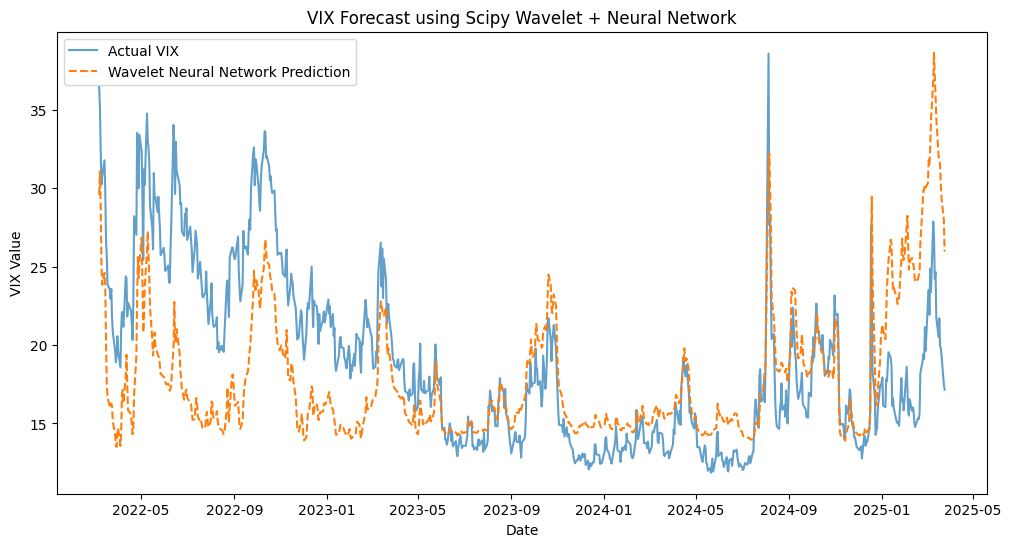

In [ ]:
!pip install tensorflow
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.signal import cwt, ricker
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import datetime as dt

# Get today's date for real-time analysis
end_time = dt.date.today().strftime("%Y-%m-%d")

# Step 1: Download VIX Data
vix = yf.download("^VIX", start="2010-01-01", end=end_time)

# Check if data was successfully downloaded
if vix.empty:
    raise ValueError("Yahoo Finance returned an empty dataset. Check the ticker or API availability.")

# Fix missing 'Close' column issue
if 'Close' not in vix.columns:
    vix['Close'] = vix.get('Adj Close', vix.get('close', vix.get('adj close')))

vix = vix[['Close']].dropna().reset_index()  # Keep only Close column & clean data

# Step 2: Apply Continuous Wavelet Transform (CWT) using Ricker Wavelet
widths = np.arange(1, 31)  # Define wavelet scales (acts like frequency bands)
# Reshape vix['Close'].values to a 1-dimensional array explicitly
cwt_matrix = cwt(vix['Close'].values.reshape(-1,), ricker, widths)  # Apply CWT

# Convert wavelet coefficients into a feature DataFrame
features = pd.DataFrame(cwt_matrix.T, columns=[f'Wavelet_{i+1}' for i in range(len(widths))])

# Step 3: Prepare Dataset for Neural Network
X = features  # Wavelet-based features
y = vix['Close'][:len(X)]  # Target (VIX values)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Build Wavelet Neural Network (WNN)
model = Sequential([
    Dense(64, input_shape=(X_train_scaled.shape[1],), activation='tanh'),  # Wavelet-like activation
    Dense(32, activation='tanh'),
    Dense(1, activation='linear')  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=16, validation_data=(X_test_scaled, y_test), verbose=1)

# Step 5: Forecast Future VIX Values
y_pred = model.predict(X_test_scaled).flatten()

# Evaluate Model Performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Step 6: Plot Actual vs. Predicted VIX
plt.figure(figsize=(12,6))
plt.plot(vix['Date'][-len(y_test):], y_test, label="Actual VIX", alpha=0.7)
plt.plot(vix['Date'][-len(y_test):], y_pred, label="Wavelet Neural Network Prediction", linestyle="--")
plt.legend()
plt.title("VIX Forecast using Scipy Wavelet + Neural Network")
plt.xlabel("Date")
plt.ylabel("VIX Value")
plt.show()


# VIX Forecast using Scipy Wavelet + LSTM

[*********************100%***********************]  1 of 1 completed
<ipython-input-5-018bf7d05e44>:33: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  cwt_matrix = cwt(vix['Close'].values.reshape(-1,), ricker, widths)  # Apply CWT
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 286.1657 - mae: 14.5247 - val_loss: 29.8509 - val_mae: 4.3190
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 55.3808 - mae: 5.0518 - val_loss: 27.8988 - val_mae: 4.2416
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 47.8045 - mae: 4.8349 - val_loss: 25.1470 - val_mae: 3.9929
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 44.8842 - mae: 4.7180 - val_loss: 22.6163 - val_mae: 3.9339
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 35.4559 - mae: 4.4094 - val_loss: 27.4917 - val_mae: 3.7975
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 33.9816 - mae: 4.3111 - val_loss: 29.2734 - val_mae: 3.8820
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 33.3070 - mae: 4.3369 - val_loss: 22.5941 - val_mae: 3.8685
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 29.4482 - mae: 4.1723 - val_loss: 24.2487 - val_mae: 3.7855
Epoch 9/50
192/192 ━━━━━━━━━━━━━━━━━

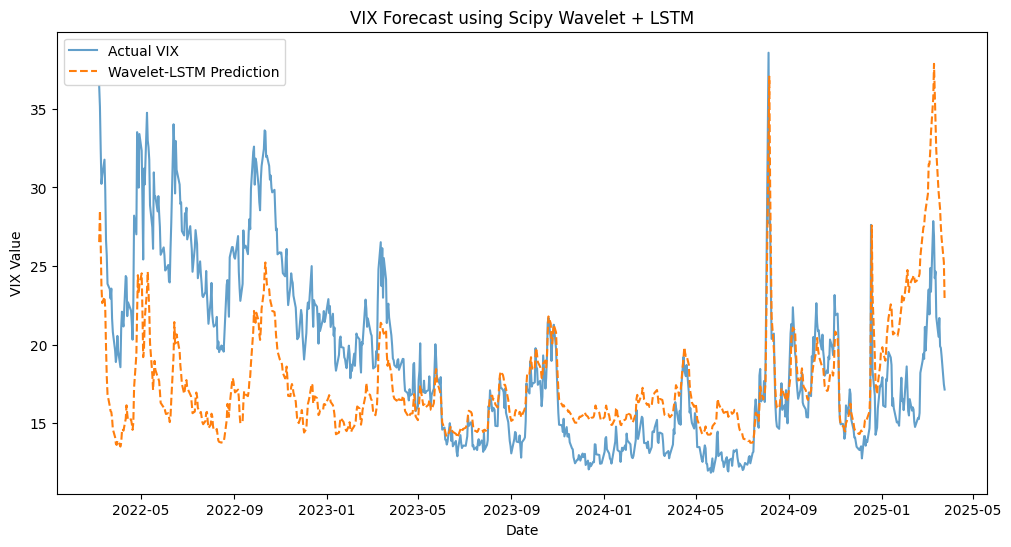

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import cwt, ricker
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import datetime as dt

# Get today's date for real-time analysis
end_time = dt.date.today().strftime("%Y-%m-%d")

# Step 1: Download VIX Data
vix = yf.download("^VIX", start="2010-01-01", end=end_time)

# Check if data was successfully downloaded
if vix.empty:
    raise ValueError("Yahoo Finance returned an empty dataset. Check the ticker or API availability.")

# Fix missing 'Close' column issue
if 'Close' not in vix.columns:
    vix['Close'] = vix.get('Adj Close', vix.get('close', vix.get('adj close')))

vix = vix[['Close']].dropna().reset_index()  # Keep only Close column & clean data

# Step 2: Apply Continuous Wavelet Transform (CWT) using Ricker Wavelet
widths = np.arange(1, 31)  # Define wavelet scales (acts like frequency bands)
# Reshape vix['Close'].values to a 1-dimensional array explicitly
cwt_matrix = cwt(vix['Close'].values.reshape(-1,), ricker, widths)  # Apply CWT

# Convert wavelet coefficients into a feature DataFrame
features = pd.DataFrame(cwt_matrix.T, columns=[f'Wavelet_{i+1}' for i in range(len(widths))])

# Step 3: Prepare Dataset for LSTM
X = features  # Wavelet-based features
y = vix['Close'][:len(X)]  # Target (VIX values)

# Normalize features using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape X for LSTM (samples, time steps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split data into training and testing sets
train_size = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:train_size], X_reshaped[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 4: Build the LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(1, X_reshaped.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Step 5: Forecast Future VIX Values
y_pred = model.predict(X_test).flatten()

# Evaluate Model Performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Step 6: Plot Actual vs. Predicted VIX
plt.figure(figsize=(12,6))
plt.plot(vix['Date'][-len(y_test):], y_test, label="Actual VIX", alpha=0.7)
plt.plot(vix['Date'][-len(y_test):], y_pred, label="Wavelet-LSTM Prediction", linestyle="--")
plt.legend()
plt.title("VIX Forecast using Scipy Wavelet + LSTM")
plt.xlabel("Date")
plt.ylabel("VIX Value")
plt.show()


# VIX Forecast using Scipy Wavelet + Transformer Model

[*********************100%***********************]  1 of 1 completed

Epoch 1/50



<ipython-input-6-a059a65504aa>:33: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  cwt_matrix = cwt(vix['Close'].values.reshape(-1,), ricker, widths)  # Apply CWT


192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 148.9252 - mae: 9.5510 - val_loss: 38.2734 - val_mae: 4.5650
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 53.7684 - mae: 4.8244 - val_loss: 29.8874 - val_mae: 4.3989
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 46.6252 - mae: 4.8796 - val_loss: 29.7258 - val_mae: 4.4792
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 52.0061 - mae: 4.9196 - val_loss: 35.2756 - val_mae: 4.3460
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 42.8080 - mae: 4.4227 - val_loss: 25.7077 - val_mae: 3.9578
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 33.5494 - mae: 4.0884 - val_loss: 23.2951 - val_mae: 3.8199
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 32.8002 - mae: 3.9246 - val_loss: 27.4778 - val_mae: 3.9620
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 30.0406 - mae: 3.8234 - val_loss: 26.0033 - val_mae: 3.9851
Epoch 9/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/ste

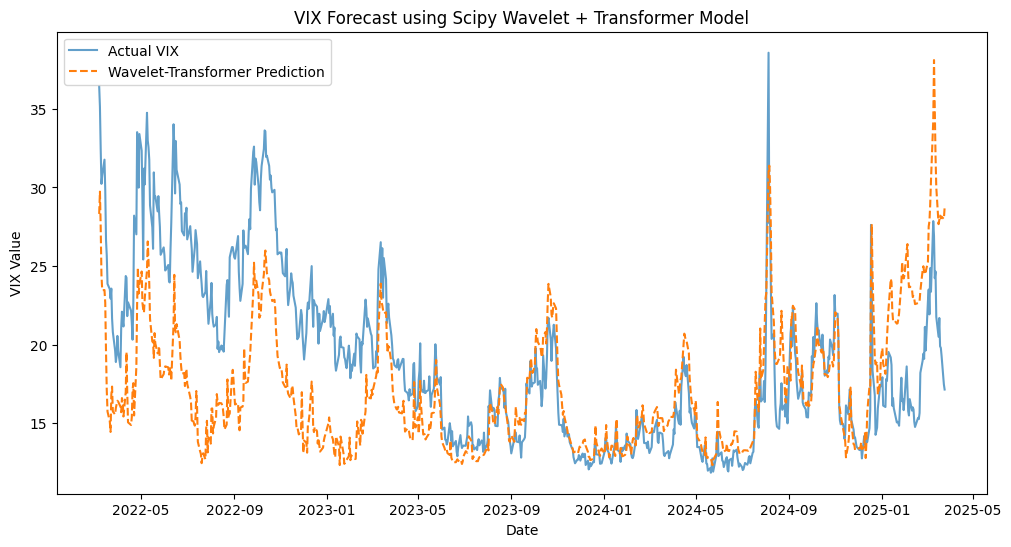

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.signal import cwt, ricker
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
import datetime as dt

# Get today's date for real-time analysis
end_time = dt.date.today().strftime("%Y-%m-%d")

# Step 1: Download VIX Data
vix = yf.download("^VIX", start="2010-01-01", end=end_time)

# Check if data was successfully downloaded
if vix.empty:
    raise ValueError("Yahoo Finance returned an empty dataset. Check the ticker or API availability.")

# Fix missing 'Close' column issue
if 'Close' not in vix.columns:
    vix['Close'] = vix.get('Adj Close', vix.get('close', vix.get('adj close')))

vix = vix[['Close']].dropna().reset_index()  # Keep only Close column & clean data

# Step 2: Apply Continuous Wavelet Transform (CWT) using Ricker Wavelet
widths = np.arange(1, 31)  # Define wavelet scales (acts like frequency bands)
# Reshape vix['Close'].values to a 1-dimensional array explicitly
cwt_matrix = cwt(vix['Close'].values.reshape(-1,), ricker, widths)  # Apply CWT

# Convert wavelet coefficients into a feature DataFrame
features = pd.DataFrame(cwt_matrix.T, columns=[f'Wavelet_{i+1}' for i in range(len(widths))])

# Step 3: Prepare Dataset for Transformer
X = features  # Wavelet-based features
y = vix['Close'][:len(X)]  # Target (VIX values)

# Normalize features using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape X for Transformer (batch_size, sequence_length, feature_size)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split data into training and testing sets
train_size = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:train_size], X_reshaped[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 4: Build the Transformer Model
def build_transformer(input_shape, num_heads=4, ff_dim=64, dropout_rate=0.1):
    inputs = Input(shape=input_shape)

    # Multi-Head Self Attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(inputs, inputs)
    attn_output = Dropout(dropout_rate)(attn_output)
    attn_output = LayerNormalization(epsilon=1e-6)(attn_output + inputs)

    # Feed Forward Layer
    ff_output = Dense(ff_dim, activation="relu")(attn_output)
    ff_output = Dense(input_shape[-1])(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    ff_output = LayerNormalization(epsilon=1e-6)(ff_output + attn_output)

    # Global Average Pooling
    pooled_output = GlobalAveragePooling1D()(ff_output)

    # Final Regression Output
    outputs = Dense(1, activation="linear")(pooled_output)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Initialize Transformer Model
transformer_model = build_transformer(input_shape=(1, X_reshaped.shape[2]))

# Compile the model
transformer_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = transformer_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Step 5: Forecast Future VIX Values
y_pred = transformer_model.predict(X_test).flatten()

# Evaluate Model Performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Step 6: Plot Actual vs. Predicted VIX
plt.figure(figsize=(12,6))
plt.plot(vix['Date'][-len(y_test):], y_test, label="Actual VIX", alpha=0.7)
plt.plot(vix['Date'][-len(y_test):], y_pred, label="Wavelet-Transformer Prediction", linestyle="--")
plt.legend()
plt.title("VIX Forecast using Scipy Wavelet + Transformer Model")
plt.xlabel("Date")
plt.ylabel("VIX Value")
plt.show()


# VIX Forecast using Scipy Wavelet + Bayesian Ridge Regression

[*********************100%***********************]  1 of 1 completed
<ipython-input-7-1166c0a752f5>:31: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  cwt_matrix = cwt(vix['Close'].values.reshape(-1,), ricker, widths)  # Apply CWT
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Absolute Error (MAE): 3.91
Root Mean Squared Error (RMSE): 4.51


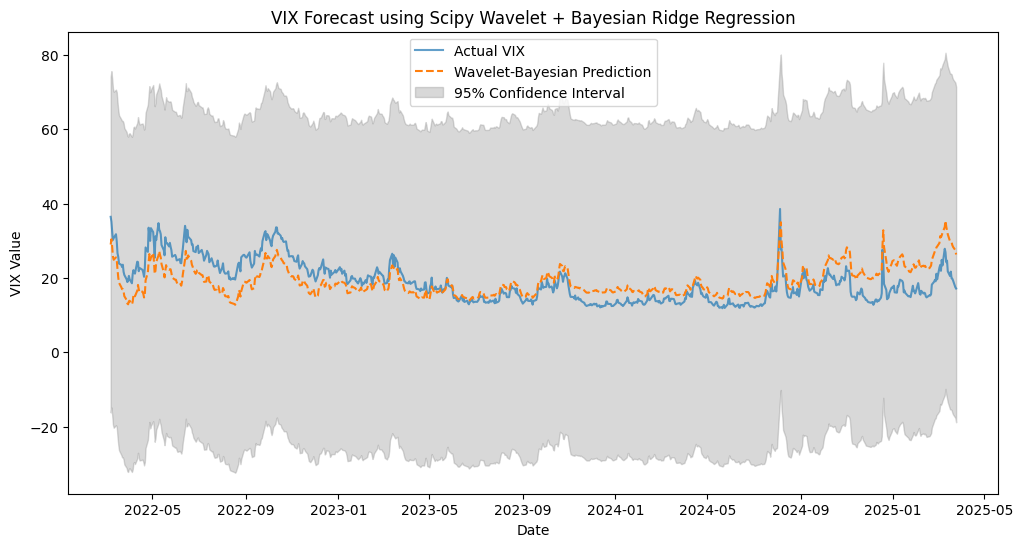

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.signal import cwt, ricker
from sklearn.linear_model import BayesianRidge
import datetime as dt

# Get today's date for real-time analysis
end_time = dt.date.today().strftime("%Y-%m-%d")

# Step 1: Download VIX Data
vix = yf.download("^VIX", start="2010-01-01", end=end_time)

# Check if data was successfully downloaded
if vix.empty:
    raise ValueError("Yahoo Finance returned an empty dataset. Check the ticker or API availability.")

# Fix missing 'Close' column issue
if 'Close' not in vix.columns:
    vix['Close'] = vix.get('Adj Close', vix.get('close', vix.get('adj close')))

vix = vix[['Close']].dropna().reset_index()  # Keep only Close column & clean data

# Step 2: Apply Continuous Wavelet Transform (CWT) using Ricker Wavelet
widths = np.arange(1, 31)  # Define wavelet scales (acts like frequency bands)
# Reshape vix['Close'].values to a 1-dimensional array explicitly
cwt_matrix = cwt(vix['Close'].values.reshape(-1,), ricker, widths)  # Apply CWT

# Convert wavelet coefficients into a feature DataFrame
features = pd.DataFrame(cwt_matrix.T, columns=[f'Wavelet_{i+1}' for i in range(len(widths))])

# Step 3: Prepare Dataset for Bayesian Regression
X = features  # Wavelet-based features
y = vix['Close'][:len(X)]  # Target (VIX values)

# Normalize features using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Step 4: Train Bayesian Ridge Regression Model
bayesian_model = BayesianRidge()
bayesian_model.fit(X_train, y_train)

# Step 5: Forecast Future VIX Values
y_pred, y_std = bayesian_model.predict(X_test, return_std=True)  # Get confidence intervals

# Evaluate Model Performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Step 6: Plot Actual vs. Predicted VIX with Confidence Intervals
plt.figure(figsize=(12,6))
plt.plot(vix['Date'][-len(y_test):], y_test, label="Actual VIX", alpha=0.7)
plt.plot(vix['Date'][-len(y_test):], y_pred, label="Wavelet-Bayesian Prediction", linestyle="--")
plt.fill_between(vix['Date'][-len(y_test):], y_pred - 2*y_std, y_pred + 2*y_std, color='gray', alpha=0.3, label="95% Confidence Interval")
plt.legend()
plt.title("VIX Forecast using Scipy Wavelet + Bayesian Ridge Regression")
plt.xlabel("Date")
plt.ylabel("VIX Value")
plt.show()


# Turbulenece

In [ ]:
pip install yfinance pandas numpy scikit-learn matplotlib scipy


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


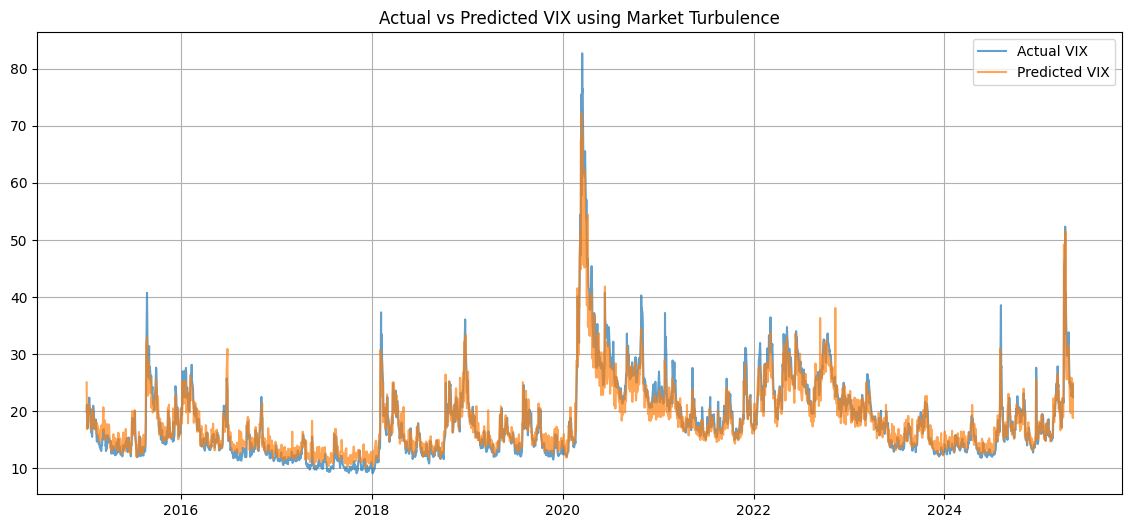

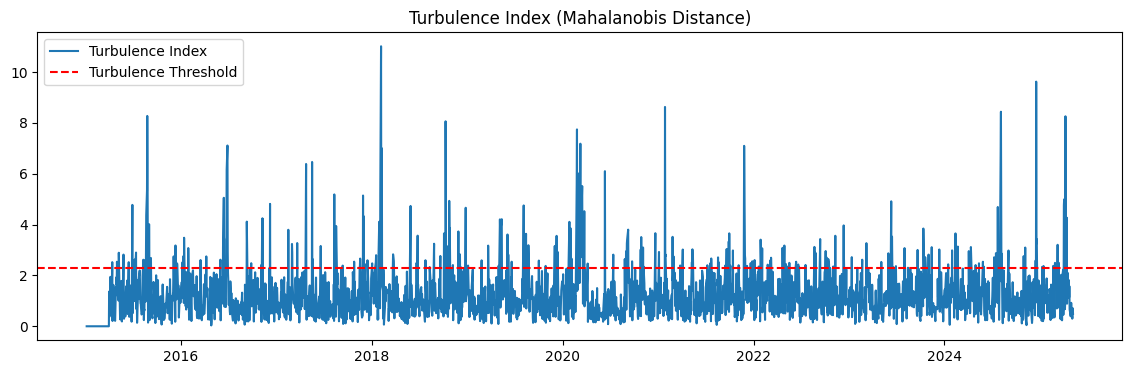

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Download data
sp500 = yf.download('^GSPC', start='2015-01-01')['Close']
vix = yf.download('^VIX', start='2015-01-01')['Close']

# Align and rename
data = pd.concat([sp500, vix], axis=1)
data.columns = ['SP500', 'VIX']
data.dropna(inplace=True)

 # Compute log returns
data['SP500_ret'] = np.log(data['SP500'] / data['SP500'].shift(1))
data['VIX_ret'] = np.log(data['VIX'] / data['VIX'].shift(1))
data = data.dropna()


# 2. Calculate turbulence (Mahalanobis distance on rolling window)
def calculate_turbulence(df, window=60):
    turbulence = []
    for i in range(len(df)):
        if i < window:
            turbulence.append(0)
            continue
        hist = df.iloc[i - window:i]
        current = df.iloc[i]
        cov = np.cov(hist.T)
        if np.linalg.det(cov) == 0:
            turbulence.append(0)
        else:
            inv_cov = np.linalg.inv(cov)
            mean = hist.mean()
            dist = mahalanobis(current, mean, inv_cov)
            turbulence.append(dist)
    return pd.Series(turbulence, index=df.index)

# Now that returns exist, we can compute turbulence
features = data[['SP500_ret', 'VIX_ret']]
data['Turbulence'] = calculate_turbulence(features)

# 3. Label turbulence regimes
data['Turbulent'] = data['Turbulence'] > data['Turbulence'].rolling(60).quantile(0.9)

# 4. ML: Predict next-day VIX using current features
data['VIX_next'] = data['VIX'].shift(-1)
data = data.dropna()

X = data[['SP500_ret', 'VIX_ret', 'Turbulence']]
y = data['VIX_next']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

data['VIX_pred'] = model.predict(X)

# 5. Plot results
plt.figure(figsize=(14,6))
plt.plot(data.index, data['VIX'], label='Actual VIX', alpha=0.7)
plt.plot(data.index, data['VIX_pred'], label='Predicted VIX', alpha=0.7)
plt.title('Actual vs Predicted VIX using Market Turbulence')
plt.legend()
plt.grid()
plt.show()

# 6. Plot turbulence regime
plt.figure(figsize=(14,4))
plt.plot(data['Turbulence'], label='Turbulence Index')
plt.axhline(data['Turbulence'].rolling(60).quantile(0.9).mean(), color='r', linestyle='--', label='Turbulence Threshold')
plt.title('Turbulence Index (Mahalanobis Distance)')
plt.legend()
plt.show()


# Dynamic Mode Decomposition (DMD)

In [6]:
pip install yfinance pydmd matplotlib numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.7/152.7 kB 4.0 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed


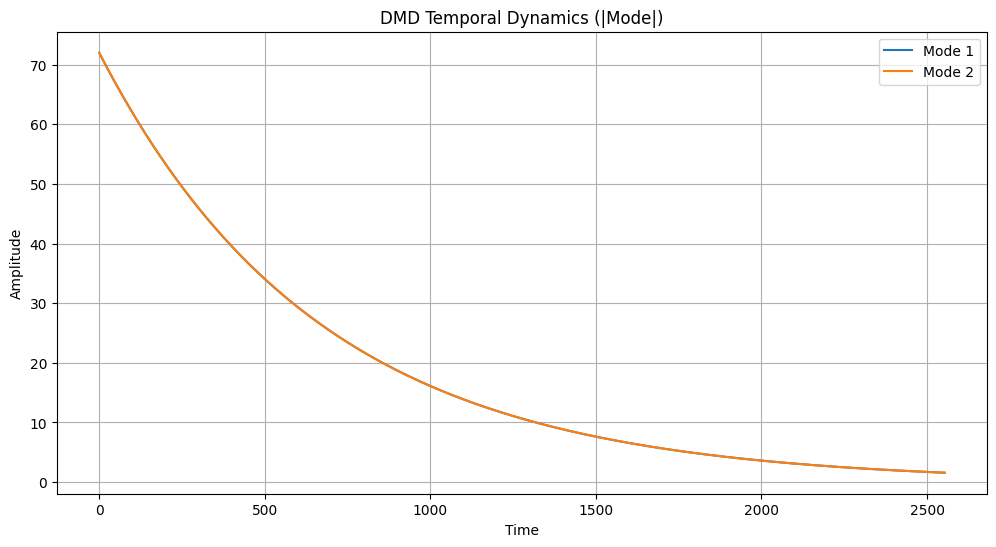

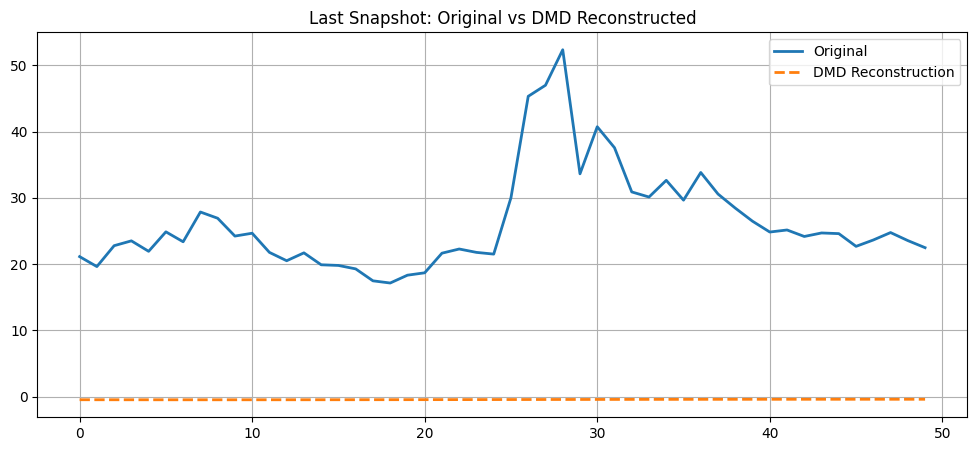

In [8]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from pydmd import DMD

# 1. Download VIX data
vix_data = yf.download('^VIX', start='2015-01-01', end='2025-05-11')['Close']
vix_data = vix_data.dropna()

# 2. Normalize and create snapshot matrix X
window_size = 50  # length of each snapshot (days)
step = 1

# Create data matrix: each column is a windowed time slice of the VIX
X = np.column_stack([vix_data.values[i:i+window_size]
                     for i in range(0, len(vix_data)-window_size, step)])

# 3. Fit DMD
dmd = DMD(svd_rank=2)  # You can try 3, 5, etc.
dmd.fit(X)

# 4. Plot DMD modes (temporal dynamics)
plt.figure(figsize=(12, 6))
for i, mode in enumerate(dmd.dynamics):
    plt.plot(np.abs(mode), label=f'Mode {i+1}')
plt.title('DMD Temporal Dynamics (|Mode|)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# 5. Optional: Reconstruct and compare to original signal
X_dmd = dmd.reconstructed_data.real

plt.figure(figsize=(12, 5))
plt.plot(X[:, -1], label='Original', linewidth=2)
plt.plot(X_dmd[:, -1], '--', label='DMD Reconstruction', linewidth=2)
plt.title('Last Snapshot: Original vs DMD Reconstructed')
plt.legend()
plt.grid(True)
plt.show()
